<a href= "https://www.kaggle.com/mnassrib/telecom-churn-datasets">Orange Telecom Churn Dataset (Link to dataset)</a>

<h4><u>Objective</u></h4>
To predict if a customer will churn from Orange Telecom Company.

<h5><u>Evaluation Metric</u></h5>
Area under the ROC Curve (AUC)

<hr>
<b>Variable Definitions</b><br>
<ul>
    <li>State: State customer is located</li>
    <li>Account length: Customer account length in days</li>
    <li>Area code: Area code of customer's location</li>
    <li>Phone number: Customer Phonenumber</li>
    <li>International plan: Does customer have International plan (Yes or No)</li>
    <li>Voicemail plan: Customer has voice mail plan (Yes or No)</li>
    <li>Number vmail messages: Customer number of voice mail messages</li>
    <li>Total day minutes: Total Call time in the daytime</li>
    <li>Total day calls: Total calls in daytime</li>
    <li>Total day charge: Total charges for calls in daytime</li>
    <li>Total eve minutes: Total Call time in the evening </li>
    <li>Total eve calls: Total calls in the evening</li>
    <li>Total eve charge: Total charges for calls in the evening</li>
    <li>Total night minutes: Total Call time at night</li>
    <li>Total night calls: Total calls at night</li>
    <li>Total night charge: Total charges for calls at night</li>
    <li>Total intl minutes: Total intl call time</li>
    <li>Total intl calls: Total Intl calls</li>
    <li>Total intl charge: Total Intl call charges</li>
    <li>Customer service calls: Customer customer service calls</li>
    <li>Churn: Target- Whether customer churned or not(True or False)</li>
</ul>

In [1]:
path = "C:/Machine_learning_datafiles/kaggle"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats as scipy_stats

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import lightgbm as lgb
import catboost as cat

In [5]:
from sklearn.base import BaseEstimator
import joblib

In [6]:
seed = 1243
random.seed(seed)
np.random.seed(seed)

In [7]:
plt.style.use('bmh')
%matplotlib inline
pd.set_option('display.max_columns', 70)

In [8]:
data= pd.read_csv(path+'./OrangeTelecomCustomerChurn.csv')

In [9]:
data.head(3)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [10]:
data.columns = data.columns.str.replace('\s', '_')

In [11]:
data[data.voice_mail_plan == 'no'].number_vmail_messages.unique()

array([0], dtype=int64)

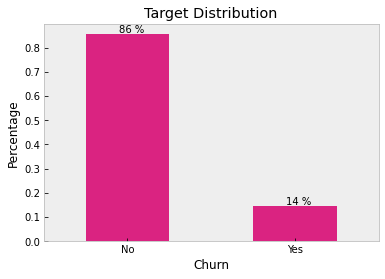

In [12]:
ax = data.churn.value_counts().transform(
    lambda x: x/x.sum()).plot.bar(
    title='Target Distribution', rot=0, color='#da2381', 
    ylabel='Percentage', xlabel='Churn')
plt.xticks(range(2), ['No', 'Yes'])

plt.grid(False)

for i in ax.patches:
    plt.text(i.get_x()+0.2, i.get_height()+0.005, str(int(round(100*i.get_height(), 0)))+' %');

In [13]:
class Preprocessor(BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        drop_cols = ['state', 'totalMinutes', 'number_vmail_messages', 'total_day_calls', 'total_eve_calls', 
                     'total_night_calls', 'total_intl_calls', 'area_code', 'phone_number',
                     'total_day_charge', 'total_eve_charge', 'total_night_charge', 'totalCalls', 'total_day_minutes', 
                     'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes']
        
        X['totalCalls'] = X[['total_day_calls', 'total_eve_calls', 
                             'total_night_calls', 'total_intl_calls']].sum(axis=1)
        
        X['totalCharges'] = X[['total_day_charge', 'total_eve_charge', 
                               'total_night_charge', 'total_intl_charge']].sum(axis=1)
        
        X['totalMinutes'] = X[['total_day_minutes', 'total_eve_minutes', 
                               'total_night_minutes', 'total_intl_minutes']].sum(axis=1)
        
        X['Call_charges_per_min'] = X['totalCharges'] / X['totalMinutes']
        X['Call_charges_per_call'] = X['totalCharges'] / X['totalCalls']
        X['Intl_charge_per_call'] = X['total_intl_charge'] / X['total_intl_calls']
        
        X[['international_plan', 'voice_mail_plan']] = X[['international_plan', 'voice_mail_plan']].apply(
            lambda x: [0 if i.lower() == 'no' else 1 for i in x])
        X.fillna(0, inplace=True) # filling missing values with zero
        return X.drop(drop_cols, axis=1)

In [14]:
def metricScores(model, x, y):
    f_score = f1_score(y, model.predict(x))
    auc_score = roc_auc_score(y, model.predict_proba(x)[:,1])
    return f_score, auc_score

def printReport(model, x, y):
    print(classification_report(y, model.predict(x),target_names=['Churn_No', 'Churn_Yes']))

def plotFigure(model, x, y, title):
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    plot_confusion_matrix(model, x, y, display_labels=['Churn_No', 'Churn_Yes'], ax=ax[0])
    plot_roc_curve(model, x, y, ax=ax[1],name=title)
    plot_precision_recall_curve(model, x, y, ax=ax[2], name=title)
    ax[0].grid(False)
    plt.tight_layout(pad=1.)

In [15]:
def featureImportance(model, x, y):
    imp= pd.Series(model.feature_importances_, index=x.columns).sort_values()
    imp.plot.barh(title=model.__class__.__name__)

In [16]:
def crossValScores(model, xtr, ytr, cv=5):
    cvs= cross_val_score(model, xtr.reset_index(drop=True), ytr.reset_index(drop=True), 
                         cv=cv, scoring='roc_auc', n_jobs=-1)
    print('Mean AUC Score: {:.3f} +- {:.3f}'.format(cvs.mean(), cvs.std()))

In [17]:
def trainModel(model, xtr, ytr, xte, yte):
    if model.__class__.__name__ in ['CatBoostClassifier', 'LGBMClassifier']:
        model.fit(xtr.reset_index(drop=True), ytr.reset_index(drop=True), 
                  eval_set =[(xtrain, ytrain), (xtest, ytest)], early_stopping_rounds=100, verbose=False)
    else:
        model.fit(xtr.reset_index(drop=True), ytr.reset_index(drop=True))
        
    te_fscore, te_auc_score= metricScores(model, xte.reset_index(drop=True), yte.reset_index(drop=True))
    tr_fscore, tr_auc_score= metricScores(model, xtr.reset_index(drop=True), ytr.reset_index(drop=True))
    
    scores = pd.DataFrame({'Train': [tr_fscore, tr_auc_score], 
                           'Test' : [te_fscore, te_auc_score]}, 
                          index=['F1', 'AUC'])
    return scores

In [18]:
X = data.drop('churn', axis=1)
y = (data.churn * 1)

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)

In [20]:
preprocess = Preprocessor()

In [21]:
preprocess.fit(xtrain)
xtrain= preprocess.transform(xtrain)
xtest= preprocess.transform(xtest)

In [22]:
xtrain.shape, xtest.shape

((2499, 9), (834, 9))

In [23]:
scaler= StandardScaler()

In [24]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

#### Crossvalidation Scores

In [25]:
crossValScores(Pipeline([
    ('scaler', scaler),
    ('logreg', LogisticRegression(random_state=seed, n_jobs=-1))
]), xtrain, ytrain)

Mean AUC Score: 0.812 +- 0.018


In [26]:
crossValScores(RandomForestClassifier(random_state=seed), xtrain, ytrain)

Mean AUC Score: 0.911 +- 0.020


In [27]:
crossValScores(GradientBoostingClassifier(random_state=seed), xtrain, ytrain)

Mean AUC Score: 0.912 +- 0.013


In [28]:
crossValScores(cat.CatBoostClassifier(random_state=seed, n_estimators=100, learning_rate=0.1), 
               xtrain, ytrain)

Mean AUC Score: 0.914 +- 0.019


In [29]:
crossValScores(lgb.LGBMClassifier(random_state=seed, n_estimators=100, learning_rate=0.07, min_child_samples=5), 
               xtrain, ytrain)

Mean AUC Score: 0.916 +- 0.021


#### Training

In [30]:
logreg = LogisticRegression(random_state=seed, n_jobs=-1)

rf= RandomForestClassifier(random_state=seed, min_samples_leaf=1, criterion='entropy', 
                           max_features=0.5, min_samples_split=2, n_jobs=-1, 
                           n_estimators=150, max_depth=9, max_samples=0.85)

gbm= GradientBoostingClassifier(random_state=seed, max_features=0.4, n_estimators=300, max_depth=4,
                                learning_rate=0.07, subsample=0.85, min_samples_leaf=2)

catm = cat.CatBoostClassifier(silent=True, n_estimators=600, learning_rate=0.055,
                              reg_lambda=4, rsm=0.6, subsample=0.8, 
                              bootstrap_type='Bernoulli', eval_metric='AUC', max_depth=6)

lgbm = lgb.LGBMClassifier(random_state=seed, n_estimators=500, min_child_samples=1, 
                          num_leaves=32, max_depth=6, learning_rate=0.07, subsample=0.85, 
                          metrics='auc', colsample_bytree=0.5, reg_lambda=4, importance_type='gain')

In [31]:
voting = VotingClassifier([
    ('rf',rf), ('gbm', gbm), ('catm', catm), ('lgbm', lgbm)],
weights=[0.2, 0.25, 0.25, 0.3], voting='soft', n_jobs=-1)

In [32]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('logreg', logreg)
])

In [33]:
trainModel(pipeline, xtrain, ytrain, xtest, ytest)

,Train,Test
F1,0.323232,0.307692
AUC,0.816850,0.824534


In [34]:
trainModel(rf, xtrain, ytrain, xtest, ytest)

,Train,Test
F1,0.912913,0.929204
AUC,0.999541,0.954470


In [35]:
trainModel(gbm, xtrain, ytrain, xtest, ytest)

,Train,Test
F1,0.981716,0.938596
AUC,1.000000,0.953867


In [36]:
trainModel(catm, xtrain, ytrain, xtest, ytest)

,Train,Test
F1,0.944606,0.938596
AUC,0.999959,0.953728


In [37]:
trainModel(lgbm, xtrain, ytrain, xtest, ytest)

,Train,Test
F1,0.985994,0.938596
AUC,0.999997,0.953636


In [38]:
trainModel(voting, xtrain, ytrain, xtest, ytest)

,Train,Test
F1,0.981716,0.938596
AUC,1.000000,0.952766


Model Diagnostics

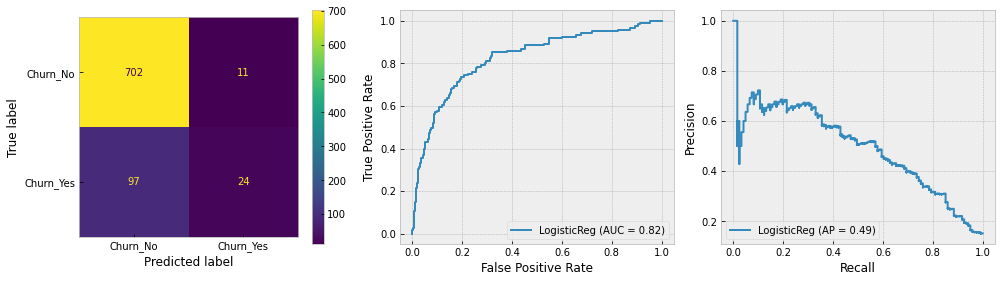

In [39]:
plotFigure(pipeline, xtest, ytest, 'LogisticReg');

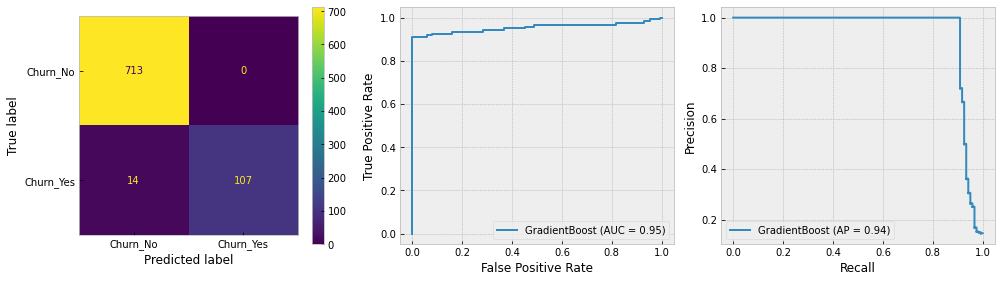

In [40]:
plotFigure(gbm, xtest, ytest, 'GradientBoost');

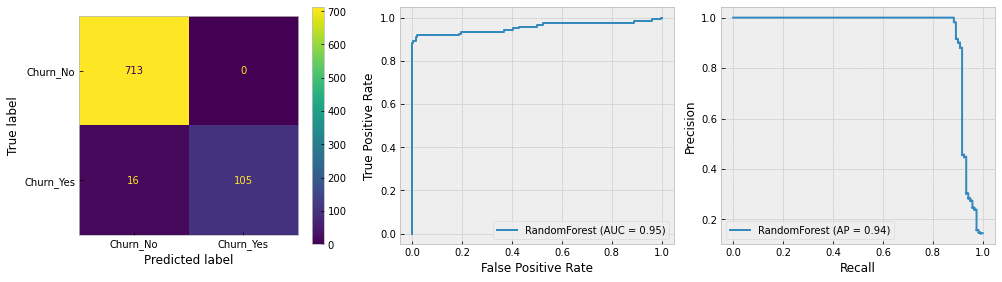

In [41]:
plotFigure(rf, xtest, ytest, 'RandomForest');

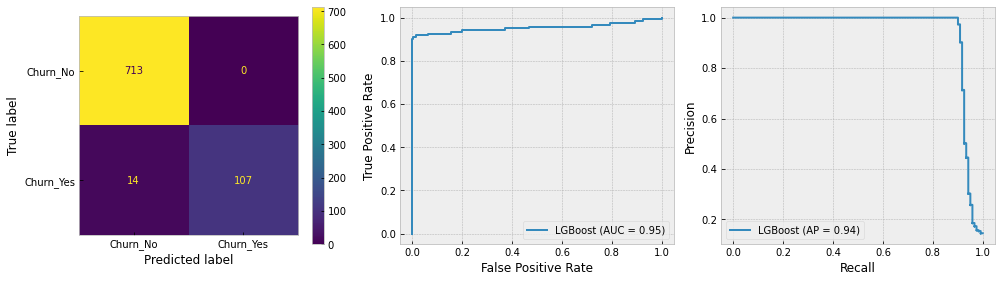

In [42]:
plotFigure(lgbm, xtest, ytest, 'LGBoost');

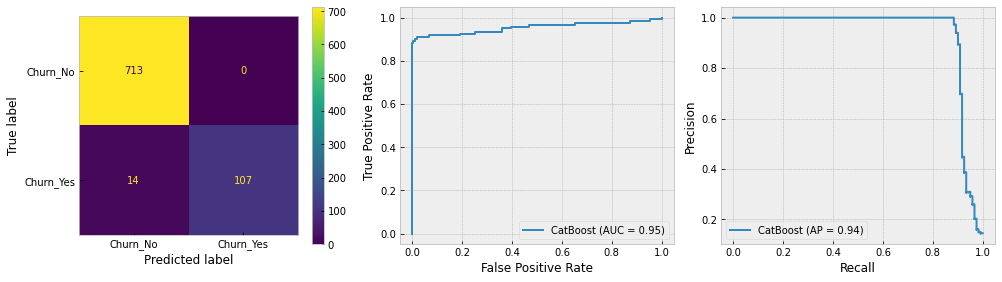

In [43]:
plotFigure(catm, xtest, ytest, 'CatBoost');

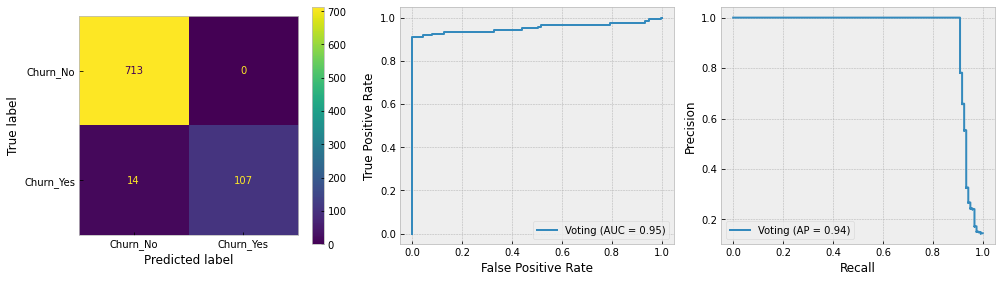

In [44]:
plotFigure(voting, xtest, ytest, 'Voting');

In [45]:
printReport(rf, xtest, ytest)

              precision    recall  f1-score   support

    Churn_No       0.98      1.00      0.99       713
   Churn_Yes       1.00      0.87      0.93       121

    accuracy                           0.98       834
   macro avg       0.99      0.93      0.96       834
weighted avg       0.98      0.98      0.98       834



In [46]:
printReport(gbm, xtest, ytest)

              precision    recall  f1-score   support

    Churn_No       0.98      1.00      0.99       713
   Churn_Yes       1.00      0.88      0.94       121

    accuracy                           0.98       834
   macro avg       0.99      0.94      0.96       834
weighted avg       0.98      0.98      0.98       834



In [47]:
printReport(lgbm, xtest, ytest)

              precision    recall  f1-score   support

    Churn_No       0.98      1.00      0.99       713
   Churn_Yes       1.00      0.88      0.94       121

    accuracy                           0.98       834
   macro avg       0.99      0.94      0.96       834
weighted avg       0.98      0.98      0.98       834



In [48]:
printReport(catm, xtest, ytest)

              precision    recall  f1-score   support

    Churn_No       0.98      1.00      0.99       713
   Churn_Yes       1.00      0.88      0.94       121

    accuracy                           0.98       834
   macro avg       0.99      0.94      0.96       834
weighted avg       0.98      0.98      0.98       834



In [49]:
printReport(voting, xtest, ytest)

              precision    recall  f1-score   support

    Churn_No       0.98      1.00      0.99       713
   Churn_Yes       1.00      0.88      0.94       121

    accuracy                           0.98       834
   macro avg       0.99      0.94      0.96       834
weighted avg       0.98      0.98      0.98       834



Plotting

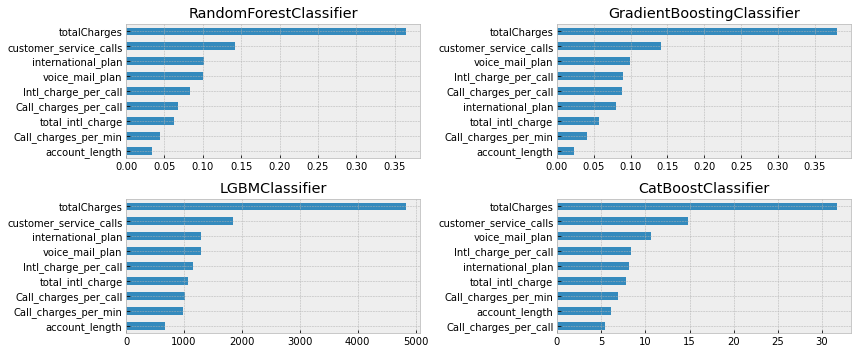

In [50]:
plt.figure(figsize=(12,6))
plt.subplot(221)
featureImportance(rf, xtest, ytest)
plt.subplot(222)
featureImportance(gbm, xtest, ytest)
plt.subplot(223)
featureImportance(lgbm, xtest, ytest)
plt.subplot(224)
featureImportance(catm, xtest, ytest)
plt.tight_layout(pad=1.);

<hr>
Model Saving

In [51]:
joblib.dump(rf, 'rforest.pkl', compress=4)
joblib.dump(gbm, 'gboost.pkl', compress=4)
joblib.dump(lgbm, 'lgboost.pkl', compress=4)
joblib.dump(catm, 'catboost.pkl', compress=4)
joblib.dump(voting, 'voting.pkl', compress=4)
joblib.dump(preprocess, 'preprocessor.pkl', compress=4);

['preprocessor.pkl']

<hr>
CROSS VALIDATION

In [52]:
X_ = preprocess.transform(X)

In [53]:
crossValScores(rf, X_, y, cv=skfold)

Mean AUC Score: 0.925 +- 0.025


In [54]:
crossValScores(gbm, X_, y, cv=skfold)

Mean AUC Score: 0.926 +- 0.027


In [55]:
crossValScores(lgbm, X_, y, cv=skfold)

Mean AUC Score: 0.926 +- 0.029


In [56]:
crossValScores(catm, X_, y, cv=skfold)

Mean AUC Score: 0.929 +- 0.017


In [57]:
crossValScores(voting, X_, y, cv=skfold)

Mean AUC Score: 0.927 +- 0.025
